<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/TestonValidation9amppatient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [82]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/UnetNEWIMAGES-5e-5-drop0.2 (1).h5", compile=False)

In [83]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [84]:

seed=42
from keras.preprocessing.image import ImageDataGenerator

In [112]:

val_img_path = "/gdrive/MyDrive/TESI/adjustedROI/final_output/val_images_09"
val_mask_path = "/gdrive/MyDrive/TESI/adjustedROI/final_output/val_masks_09"

In [113]:
img_data_gen_args_val = dict(rescale=1./255)

mask_data_gen_args_val = dict(
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                     
                     ) #Binarize the output again. 

image_data_generator_val = ImageDataGenerator(**img_data_gen_args_val)
mask_data_generator_val = ImageDataGenerator(**mask_data_gen_args_val)

In [114]:
batch_size=16


In [115]:
import os

In [116]:

seed=42


valid_img_generator = image_data_generator_val.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=159, 
                                                               color_mode = 'grayscale', 
                                                               shuffle=True,
                                                               
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator_val.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=159, 
                                                               target_size=(256,256),
                                                               shuffle=True,
                                                               
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


val_generator = zip(valid_img_generator, valid_mask_generator)

Found 159 images belonging to 1 classes.
Found 159 images belonging to 1 classes.


In [117]:
a,b=val_generator.__next__()

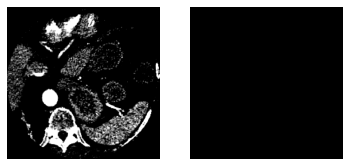

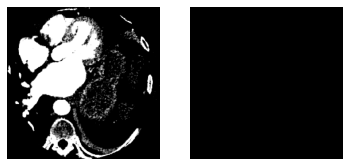

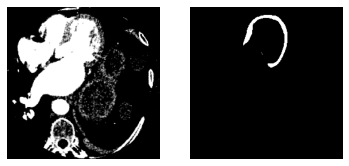

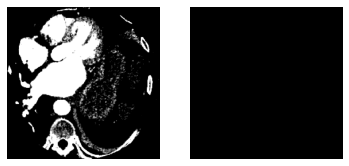

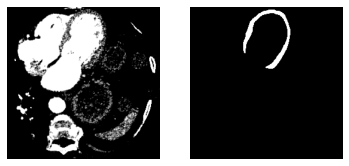

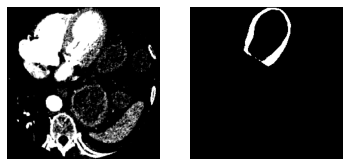

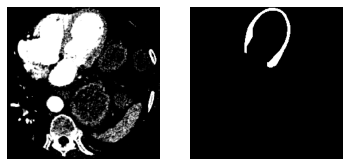

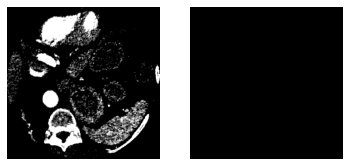

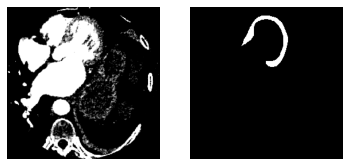

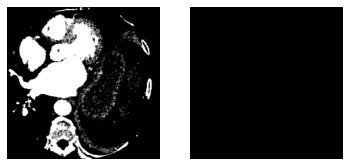

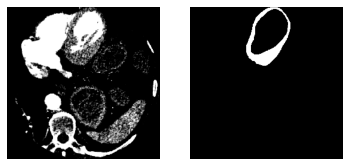

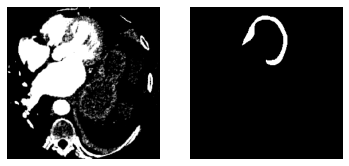

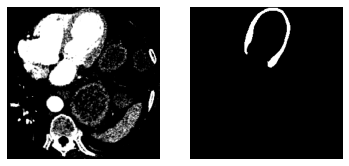

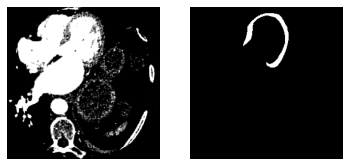

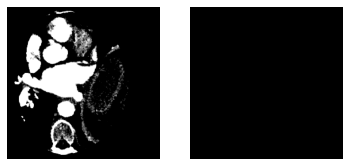

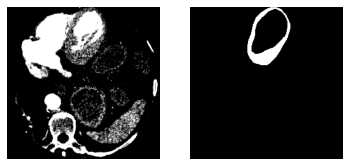

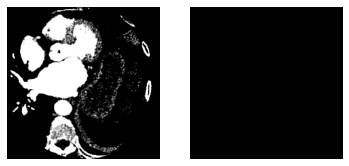

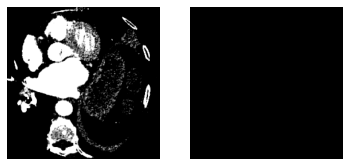

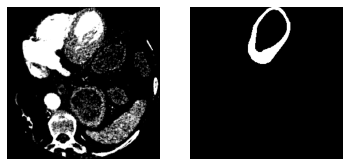

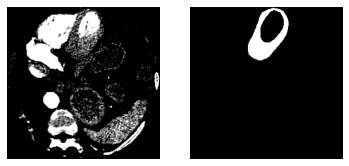

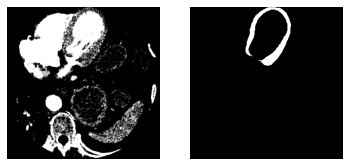

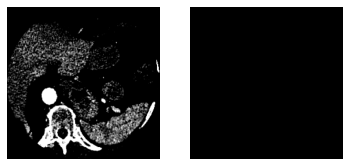

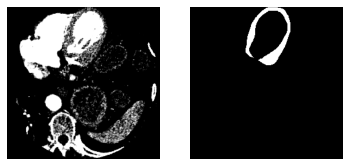

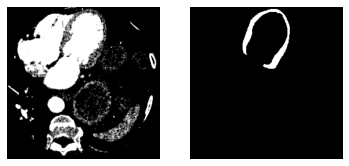

In [118]:
for i in range(0,120,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

In [119]:
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy, IoU

1/1 [==============================] - 0s 134ms/step


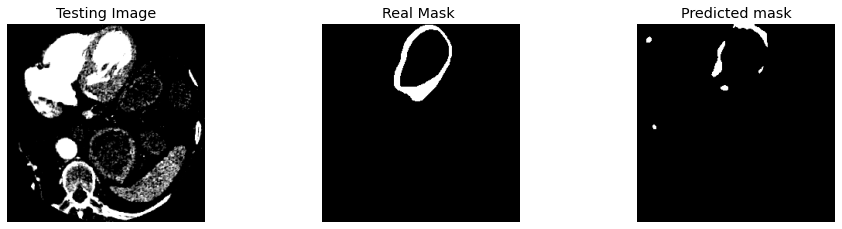

In [120]:

  test_img_number = random.randint(0,a.shape[0]-1)
  test_img = a[test_img_number]
  ground_truth=b[test_img_number]


  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.float32)
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.axis('off')
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')



  plt.subplot(232)
  plt.title('Real Mask ')
  plt.axis('off')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)

  plt.axis('off')

  plt.title('Predicted mask')
  plt.imshow(prediction, cmap='gray')

  plt.show()

In [121]:
from tensorflow.keras.metrics import MeanIoU


In [122]:
#MeanIoU for a single image
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5772026


1/1 [==============================] - 0s 136ms/step
1.0
1/1 [==============================] - 0s 137ms/step
0.6800902
1/1 [==============================] - 0s 125ms/step
0.6131589
1/1 [==============================] - 0s 129ms/step
1.0
1/1 [==============================] - 0s 122ms/step
0.47803497
1/1 [==============================] - 0s 117ms/step
0.4972
1/1 [==============================] - 0s 133ms/step
0.6536469
1/1 [==============================] - 0s 131ms/step
1.0
1/1 [==============================] - 0s 120ms/step
0.4818573
1/1 [==============================] - 0s 117ms/step
0.63606393
1/1 [==============================] - 0s 128ms/step
0.6088509
1/1 [==============================] - 0s 116ms/step
0.49991608
1/1 [==============================] - 0s 120ms/step
0.67719287
1/1 [==============================] - 0s 119ms/step
1.0
1/1 [==============================] - 0s 119ms/step
0.6750426
1/1 [==============================] - 0s 119ms/step
0.4990692
1/1 [==========

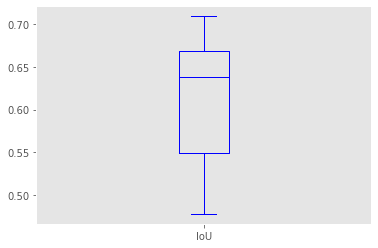

In [123]:
#MeanIoU for all images
from tensorflow.keras.metrics import MeanIoU


IoU_values = []
for img in range(a.shape[0]-1):


      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
      
      IoU = MeanIoU(num_classes=n_classes)

      IoU.update_state(ground_truth[:,:,0], prediction)

      IoU = IoU.result().numpy()
      IoU_values.append(IoU)


      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False,vert=True  # vertical box alignment
                     ,color='b')  # fill with color)
std=df.std()
median=df.median()
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)
print('median is ',median)

1/1 [==============================] - 0s 118ms/step
1.0
1/1 [==============================] - 0s 125ms/step
0.98036194
1/1 [==============================] - 0s 117ms/step
0.97462463
1/1 [==============================] - 0s 121ms/step
1.0
1/1 [==============================] - 0s 132ms/step
0.95606995
1/1 [==============================] - 0s 138ms/step
0.9944
1/1 [==============================] - 0s 139ms/step
0.97846985
1/1 [==============================] - 0s 128ms/step
1.0
1/1 [==============================] - 0s 114ms/step
0.9637146
1/1 [==============================] - 0s 125ms/step
0.9780121
1/1 [==============================] - 0s 119ms/step
0.986084
1/1 [==============================] - 0s 123ms/step
0.99983215
1/1 [==============================] - 0s 124ms/step
0.98576355
1/1 [==============================] - 0s 130ms/step
1.0
1/1 [==============================] - 0s 113ms/step
0.98661804
1/1 [==============================] - 0s 123ms/step
0.9981384
1/1 [========

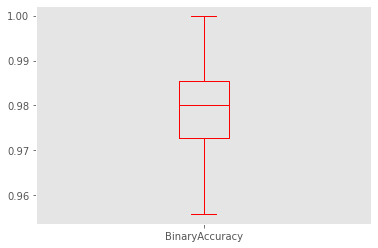

In [124]:
#Binary Accuracy for all images
import pandas as pd
BinaryAccuracy_values = []
for img in range(a.shape[0]-1):
      temp_img = a[img]
      ground_truth=b[img]
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      Accuracy=BinaryAccuracy()
      Accuracy.update_state(ground_truth[:,:,0], prediction)
      Accuracy = Accuracy.result().numpy()
      BinaryAccuracy_values.append(Accuracy)

      print(Accuracy)
      

df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='r')
std=df.std()

print("Mean acc is: ", mean_acc)
print("standard deviation is ",std)

1/1 [==============================] - 0s 123ms/step
1.0
1/1 [==============================] - 0s 126ms/step
0.7946264080032229
1/1 [==============================] - 0s 127ms/step
0.8123288456308438
1/1 [==============================] - 0s 120ms/step
1.0
1/1 [==============================] - 0s 123ms/step
0.73828125
1/1 [==============================] - 0s 129ms/step
1.0
1/1 [==============================] - 0s 127ms/step
0.8267999020248467
1/1 [==============================] - 0s 121ms/step
1.0
1/1 [==============================] - 0s 129ms/step
0.73828125
1/1 [==============================] - 0s 123ms/step
0.823232704943131
1/1 [==============================] - 0s 121ms/step
0.7583707930707595
1/1 [==============================] - 0s 131ms/step
1.0
1/1 [==============================] - 0s 125ms/step
0.8168374656757478
1/1 [==============================] - 0s 128ms/step
1.0
1/1 [==============================] - 0s 136ms/step
0.7868104127127256
1/1 [======================

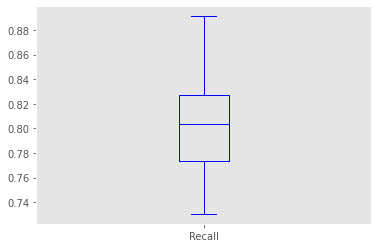

In [125]:
#Recall for all images
Recall_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Recall_values.append (recall)
    print(recall)


df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
boxplot = df.boxplot(grid=False,vert=True,color='blue')
mean_rec = df.mean().values
std=df.std()
print("Mean Recall is: ", mean_rec)
print("standard deviation is ",std)


1/1 [==============================] - 0s 127ms/step
1.0
1/1 [==============================] - 0s 116ms/step
0.9019740392772486
1/1 [==============================] - 0s 124ms/step
0.807688746848184
1/1 [==============================] - 0s 134ms/step
1.0
1/1 [==============================] - 0s 123ms/step
0.91796875
1/1 [==============================] - 0s 121ms/step
0.8359375
1/1 [==============================] - 0s 126ms/step
0.8613265484119703
1/1 [==============================] - 0s 119ms/step
1.0
1/1 [==============================] - 0s 122ms/step
0.9765625
1/1 [==============================] - 0s 124ms/step
0.8557135135393406
1/1 [==============================] - 0s 123ms/step
0.9269603114151348
1/1 [==============================] - 0s 118ms/step
0.98046875
1/1 [==============================] - 0s 130ms/step
0.9100199574979968
1/1 [==============================] - 0s 120ms/step
1.0
1/1 [==============================] - 0s 133ms/step
0.9494811304411674
1/1 [==========

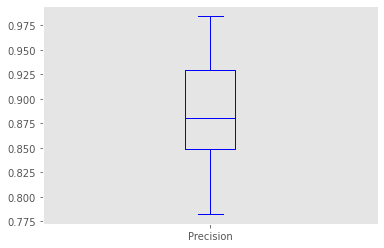

In [126]:
#Precision for all images
Precision_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
    precision=precision_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
    Precision_values.append (precision)
    print(precision)


df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_precision = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='blue')
std=df.std()
print("Mean Precision is: ", mean_precision)
print("standard deviation is ",std)


1/1 [==============================] - 0s 126ms/step
0.6800902
1/1 [==============================] - 0s 117ms/step
0.6131589
1/1 [==============================] - 0s 125ms/step
0.47803497
1/1 [==============================] - 0s 125ms/step
0.6536469
1/1 [==============================] - 0s 120ms/step
0.4818573
1/1 [==============================] - 0s 117ms/step
0.63606393
1/1 [==============================] - 0s 123ms/step
0.6088509
1/1 [==============================] - 0s 122ms/step
0.67719287
1/1 [==============================] - 0s 125ms/step
0.6750426
1/1 [==============================] - 0s 126ms/step
0.56876576
1/1 [==============================] - 0s 115ms/step
0.48106384
1/1 [==============================] - 0s 131ms/step
0.6811396
1/1 [==============================] - 0s 129ms/step
0.64718384
1/1 [==============================] - 0s 129ms/step
0.6298616
1/1 [==============================] - 0s 126ms/step
0.6684097
1/1 [==============================] - 0s 116ms/s

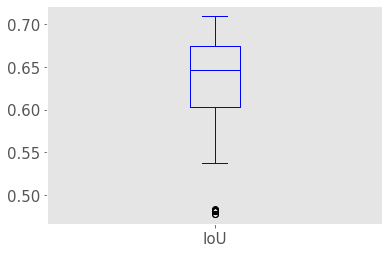

In [127]:
#MeanIoU for all images excluding black mask
from tensorflow.keras.metrics import MeanIoU
IoU_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.float32)
      
      IoU = MeanIoU(num_classes=n_classes)

      IoU.update_state(ground_truth[:,:,0], prediction)

      IoU = IoU.result().numpy()
      IoU_values.append(IoU)


      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
boxplot = df.boxplot(grid=False,vert=True,color='b',fontsize=15)
std=df.std()
print('number of real masks is : ', len(IoU_values))
print("Mean IoU is: ", mean_IoU)
print("standard deviation is ",std)

1/1 [==============================] - 0s 125ms/step
0.98036194
1/1 [==============================] - 0s 125ms/step
0.97462463
1/1 [==============================] - 0s 133ms/step
0.95606995
1/1 [==============================] - 0s 132ms/step
0.97846985
1/1 [==============================] - 0s 124ms/step
0.9637146
1/1 [==============================] - 0s 118ms/step
0.9780121
1/1 [==============================] - 0s 128ms/step
0.986084
1/1 [==============================] - 0s 121ms/step
0.98576355
1/1 [==============================] - 0s 142ms/step
0.98661804
1/1 [==============================] - 0s 127ms/step
0.9702606
1/1 [==============================] - 0s 123ms/step
0.9621277
1/1 [==============================] - 0s 126ms/step
0.9855194
1/1 [==============================] - 0s 139ms/step
0.97743225
1/1 [==============================] - 0s 132ms/step
0.98683167
1/1 [==============================] - 0s 124ms/step
0.98394775
1/1 [==============================] - 0s 129ms

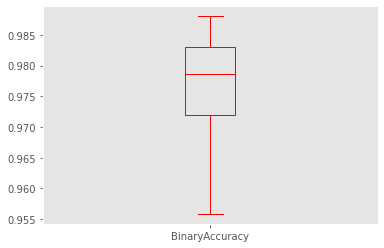

In [128]:
#Binary Accuracy for all images excluding black masks
import pandas as pd
BinaryAccuracy_values = []
for img in range(a.shape[0]-1):
      temp_img = a[img]
      ground_truth=b[img]
      if (ground_truth.max()>0):

        temp_img_input=np.expand_dims(temp_img, 0)
        prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
        Accuracy=BinaryAccuracy()
        Accuracy.update_state(ground_truth[:,:,0], prediction)
        Accuracy = Accuracy.result().numpy()
        BinaryAccuracy_values.append(Accuracy)

        print(Accuracy)
      
print('number of images is :', len(BinaryAccuracy_values))
df = pd.DataFrame(BinaryAccuracy_values, columns=["BinaryAccuracy"])
df = df[df.BinaryAccuracy != 1.0]    
mean_acc = df.mean().values
std=df.std()

boxplot = df.boxplot(grid=False,vert=True,color='r')
print("Mean acc is: ", mean_acc)
print("standard deviation is ",std)


1/1 [==============================] - 0s 133ms/step
0.7946264080032229
1/1 [==============================] - 0s 127ms/step
0.8123288456308438
1/1 [==============================] - 0s 124ms/step
0.73828125
1/1 [==============================] - 0s 120ms/step
0.8267999020248467
1/1 [==============================] - 0s 131ms/step
0.73828125
1/1 [==============================] - 0s 130ms/step
0.823232704943131
1/1 [==============================] - 0s 118ms/step
0.7583707930707595
1/1 [==============================] - 0s 121ms/step
0.8168374656757478
1/1 [==============================] - 0s 126ms/step
0.7868104127127256
1/1 [==============================] - 0s 134ms/step
0.7574816926427131
1/1 [==============================] - 0s 126ms/step
0.73828125
1/1 [==============================] - 0s 129ms/step
0.8421534786922016
1/1 [==============================] - 0s 131ms/step
0.8434538462638934
1/1 [==============================] - 0s 124ms/step
0.7648387597179116
1/1 [============

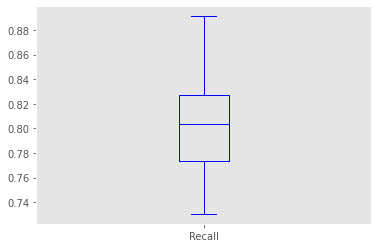

In [129]:
#Recall for all images excluding black masks
Recall_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):

      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      recall=recall_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
      Recall_values.append (recall)
      print(recall)


print('number of images is :', len(Recall_values))
df = pd.DataFrame(Recall_values, columns=["Recall"])
df = df[df.Recall != 1.0]    
mean_rec = df.mean().values
std=df.std()

boxplot = df.boxplot(grid=False,vert=True,color='b')
print("Mean recall is: ", mean_rec)
print("standard deviation is ",std)

1/1 [==============================] - 0s 118ms/step
0.9019740392772486
1/1 [==============================] - 0s 134ms/step
0.807688746848184
1/1 [==============================] - 0s 119ms/step
0.91796875
1/1 [==============================] - 0s 119ms/step
0.8613265484119703
1/1 [==============================] - 0s 123ms/step
0.9765625
1/1 [==============================] - 0s 126ms/step
0.8557135135393406
1/1 [==============================] - 0s 122ms/step
0.9269603114151348
1/1 [==============================] - 0s 115ms/step
0.9100199574979968
1/1 [==============================] - 0s 127ms/step
0.9494811304411674
1/1 [==============================] - 0s 135ms/step
0.9710787259615384
1/1 [==============================] - 0s 125ms/step
1.0
1/1 [==============================] - 0s 123ms/step
0.8906761461818935
1/1 [==============================] - 0s 120ms/step
0.8480920142160837
1/1 [==============================] - 0s 117ms/step
0.9482654496225862
1/1 [====================

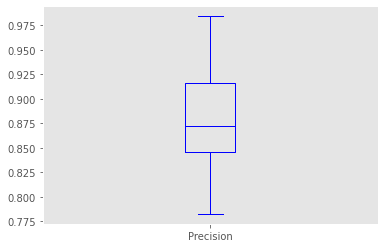

In [130]:
#Precision for all images excluding the black masks
Precision_values = []
for img in range(a.shape[0]-1):

    temp_img = a[img]
    ground_truth=b[img]
    if (ground_truth.max()>0):

      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,:,:,0]> 0.5).astype(np.uint8)
      precision=precision_score(ground_truth[:,:,0], prediction, average='macro',zero_division=1)
      Precision_values.append (precision)
      print(precision)

print('number of images is :', len(Precision_values))
df = pd.DataFrame(Precision_values, columns=["Precision"])
df = df[df.Precision != 1.0]    
mean_pre = df.mean().values
std=df.std()

boxplot = df.boxplot(grid=False,vert=True,color='b')
print("Mean precision is: ", mean_pre)
print("standard deviation is ",std)